# Tutorial 3: Align multiple ST datasets sharing identical domain types

We use STANDS to align multiple ST datasets sharing identical domain types. Specifically, this experiment involves three non-adjacent 10x Visium healthy human breast tissue datasets (10x-hNB-v05, 10x-hNB-v06, 10x-hNB-v07), which are prepared from different donors and encompass four normal domain types. In fact, the same process can be used to correct for batch effects for adjacent vertical slices.

## Loading package

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import stands
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

## Reading ST data

We read the processed ST datasets. In the example, the demo datasets includes: 1) gene expression matrix in `adata.X`; 2) spatial coordinates in `adata.obsm['spatial']`; 3) histology image in `adata.uns['spatial']`. To make the model can read the data sucessfully, please ensure the same anndata structure as example.

In [3]:
path = [
    './HumanBreast/process/V07.h5ad',
    './HumanBreast/process/V06.h5ad',
    './HumanBreast/process/V05.h5ad'
]

adata_list = []
for p in path:
    adata = sc.read_h5ad(p)
    adata_list.append(adata)

In [4]:
adata_list

[AnnData object with n_obs × n_vars = 2086 × 3000
     obs: 'cell_type', 'batch', 'disease'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 3037 × 3000
     obs: 'cell_type', 'batch', 'disease'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 2224 × 3000
     obs: 'cell_type', 'batch', 'disease'
     uns: 'spatial'
     obsm: 'spatial']

## Converting data

For ST input, STANDS first needs to convert the anndata data into a graph, where nodes represent each spot and edges represent the adjacency relationship between two spots. In the example, the node features of the converted graph include the gene expression vector and image patch. Additionally, if the data has been preprocessed, you should set `preprocess=False`. It is worth noting that STANDS converts data in the case of multiple datasets in a slightly different way than a single dataset. 

In [5]:
adata_g = stands.read_multi(adata_list, patch_size=64, n_genes=3000, preprocess=False)

## Loading the weight

The batch correction model of STANDS is initialized based on the weights of the anomaly detection model. This is partly to speed up the training process and partly to make the model more uniform in both phases. Here, `generator.pth` is the saved model weight from the anomaly detection phase.

In [6]:
generator = stands.model.GeneratorAD(gene_dim=3000, patch_size=64)
generator.load_weight('generator.pth')

## Training the model

After inputting the converted data and generator into `fit`, STANDS starts to train the style-transfer GAN. After training, the corrected data will directly replace `adata.X`, and `fit` will automatically return `adata` as output.

In [7]:
model = stands.BatchAlign(GPU='cuda:1')
adata = model.fit(adata_g, generator)

Begin to find Kin Pairs between datasets...


Train Epochs: 100%|██████████| 1000/1000 [01:40<00:00, 10.00it/s, D_Loss=-.171, G_Loss=6.84]


Kin Pairs have been found.

Begin to correct spatial transcriptomics datasets...


Train Epochs: 100%|██████████| 10/10 [00:46<00:00,  4.66s/it, D_Loss=0.28, G_Loss=1.69]


Datasets have been corrected.



## Evaluation

STANDS integrates several evaluation metrics in `stands.evaluate` for anomaly detection tasks, which can be used very easily and directly.

In [8]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2024-06-03 17:02:44.224646: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
metrics = ['ASW_type', '1-ASW_batch', 'BatchKL', 'iLISI', 'cLISI']
result = stands.evaluate(metrics, adata=adata, spaid='spatial', 
                         batchid='batch', typeid='cell_type', emb='X_umap')

In [10]:
pd.DataFrame(zip(metrics, result))

,0,1
0,ASW_type,0.603425
1,1-ASW_batch,0.918596
2,BatchKL,0.279653
3,iLISI,2.448359
4,cLISI,1.005846


## Visualization

We use the umap to visualise the results of batch alignment.

In [11]:
original = ad.concat(adata_list)
sc.pp.normalize_total(original)
sc.pp.log1p(original)
sc.pp.pca(original)
sc.pp.neighbors(original)
sc.tl.umap(original)

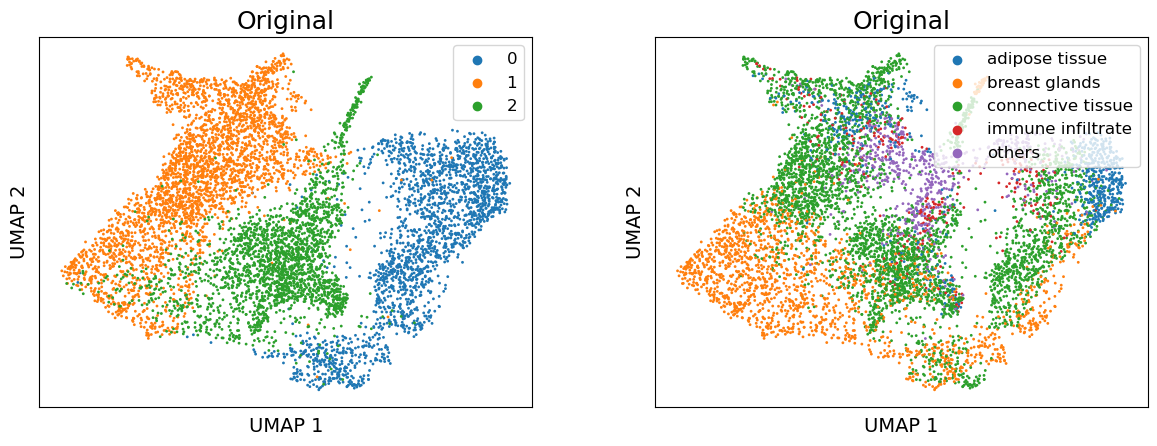

In [12]:
original.obs['batch'] = original.obs['batch'].astype('category')
ax = sc.pl.umap(original, color=['batch', 'cell_type'], show=False)

ax[0].legend(fontsize=12)
ax[0].set_title('Original', fontsize=18)
ax[0].set_xlabel('UMAP 1', fontsize=14)
ax[0].set_ylabel('UMAP 2', fontsize=14)

ax[1].legend(fontsize=12)
ax[1].set_title('Original', fontsize=18)
ax[1].set_xlabel('UMAP 1', fontsize=14)
ax[1].set_ylabel('UMAP 2', fontsize=14)

plt.show()

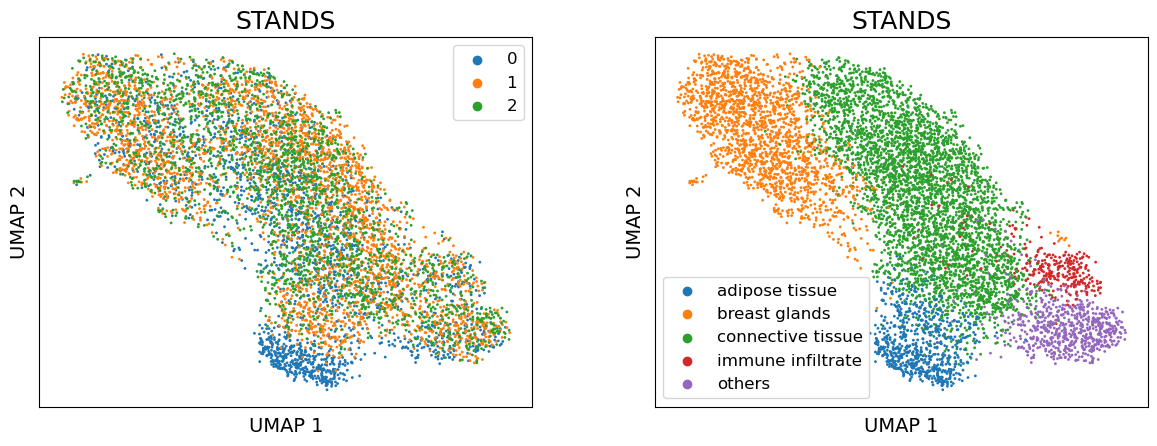

In [13]:
adata.obs['batch'] = adata.obs['batch'].astype('category')
ax = sc.pl.umap(adata, color=['batch', 'cell_type'], show=False)

ax[0].legend(fontsize=12)
ax[0].set_title('STANDS', fontsize=18)
ax[0].set_xlabel('UMAP 1', fontsize=14)
ax[0].set_ylabel('UMAP 2', fontsize=14)

ax[1].legend(fontsize=12)
ax[1].set_title('STANDS', fontsize=18)
ax[1].set_xlabel('UMAP 1', fontsize=14)
ax[1].set_ylabel('UMAP 2', fontsize=14)

plt.show()